# Visualise targets for simulation

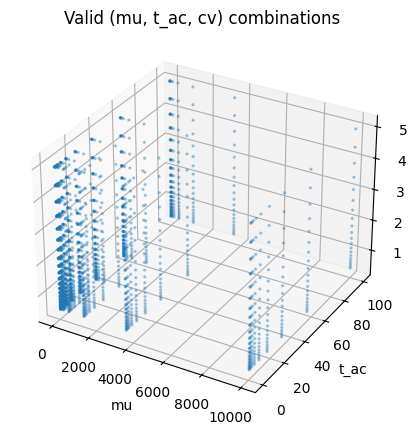

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
# Load the full grid of verified targets
mu_target = np.logspace(0, 4, 10)  # 1 to 10000
t_ac_target = np.logspace(-0.3, 2, 10)  # ~0.5 to 100
cv_target = np.logspace(-0.3, 0.7, 20)  # ~0.5 to 5
targets = np.array(np.meshgrid(mu_target, t_ac_target, cv_target)).T.reshape(-1, 3)

# Create a 3D scatter plot of mu vs t_ac vs cv
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(targets[:, 0], targets[:, 1], targets[:, 2], s=2, alpha=0.3)
ax.set_xlabel('mu')
ax.set_ylabel('t_ac')
ax.set_zlabel('cv')
ax.set_title('Valid (mu, t_ac, cv) combinations')
plt.show()


CV values range from 0.50 to 5.01.


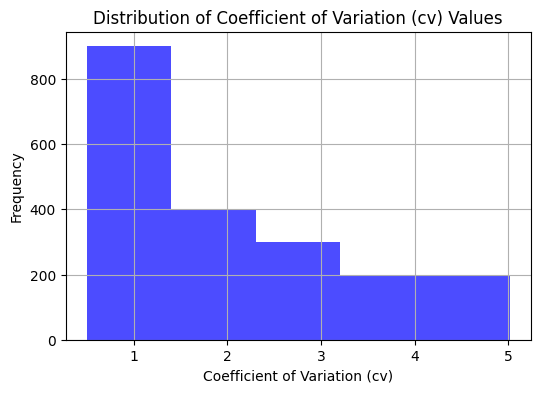

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
df_targets = pd.DataFrame(targets, columns=['mu', 't_ac', 'cv'])
# what ranges of CV values are chosen? 
cv_min = df_targets['cv'].min()
cv_max = df_targets['cv'].max()
print(f"CV values range from {cv_min:.2f} to {cv_max:.2f}.")
# plot the distribution of cv values chosen
plt.figure(figsize=(6, 4))
plt.hist(df_targets['cv'], bins=5, color='blue', alpha=0.7)
plt.xlabel('Coefficient of Variation (cv)')
plt.ylabel('Frequency')
plt.title('Distribution of Coefficient of Variation (cv) Values')
plt.grid()  
plt.show()

mu values range from 1.00 to 10000.00.


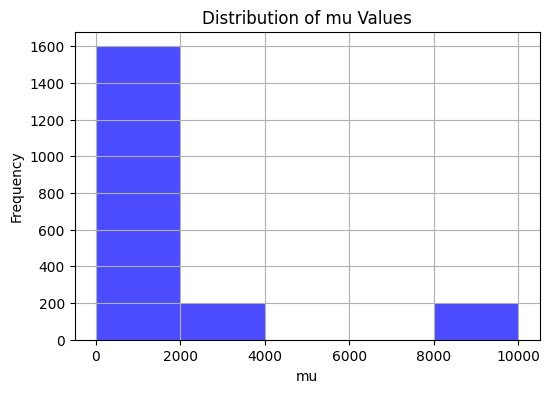

In [3]:
mu_min = df_targets['mu'].min()
mu_max = df_targets['mu'].max()
print(f"mu values range from {mu_min:.2f} to {mu_max:.2f}.")
# plot the distribution 
plt.figure(figsize=(6, 4))
plt.hist(df_targets['mu'], bins=5, color='blue', alpha=0.7)
plt.xlabel('mu')
plt.ylabel('Frequency')
plt.title('Distribution of mu Values')
plt.grid()  
plt.show()

t_ac values range from 0.50 to 100.00.


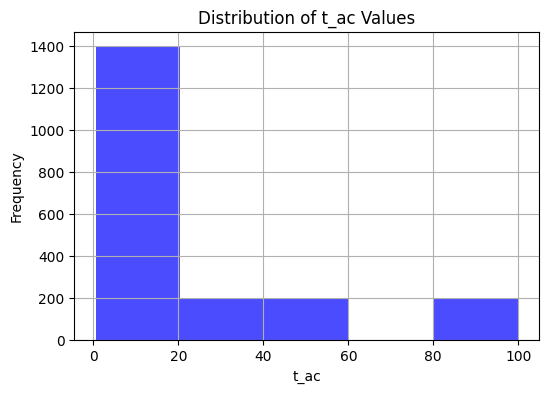

In [4]:
t_ac_min = df_targets['t_ac'].min()
t_ac_max = df_targets['t_ac'].max()
print(f"t_ac values range from {t_ac_min:.2f} to {t_ac_max:.2f}.")
# plot the distribution 
plt.figure(figsize=(6, 4))
plt.hist(df_targets['t_ac'], bins=5, color='blue', alpha=0.7)
plt.xlabel('t_ac')
plt.ylabel('Frequency')
plt.title('Distribution of t_ac Values')
plt.grid()  
plt.show()

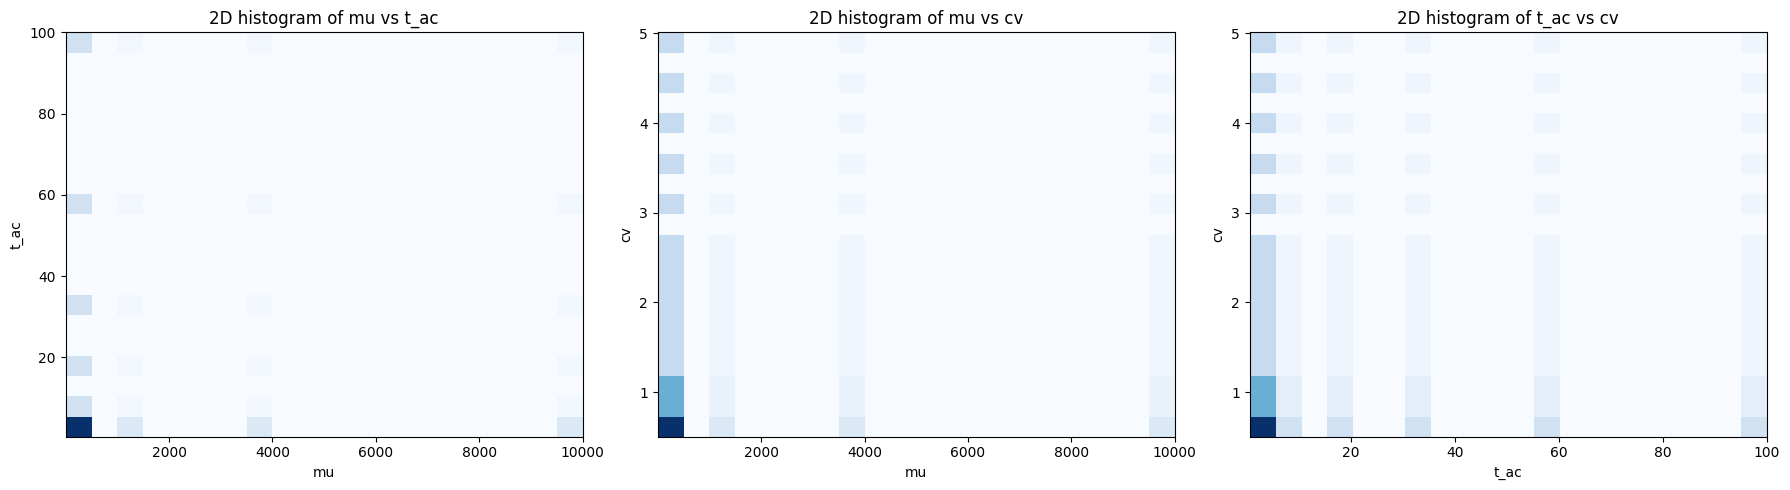

In [5]:

import matplotlib.pyplot as plt

# 2D histograms for pairwise parameter combinations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist2d(df_targets['mu'], df_targets['t_ac'], bins=20, cmap='Blues')
axes[0].set_xlabel('mu')
axes[0].set_ylabel('t_ac')
axes[0].set_title('2D histogram of mu vs t_ac')

axes[1].hist2d(df_targets['mu'], df_targets['cv'], bins=20, cmap='Blues')
axes[1].set_xlabel('mu')
axes[1].set_ylabel('cv')
axes[1].set_title('2D histogram of mu vs cv')

axes[2].hist2d(df_targets['t_ac'], df_targets['cv'], bins=20, cmap='Blues')
axes[2].set_xlabel('t_ac')
axes[2].set_ylabel('cv')
axes[2].set_title('2D histogram of t_ac vs cv')

plt.tight_layout()
plt.show()


## Sobol-sampled parameter space
This section verifies that Sobol sampling covers the parameter space evenly.

mu range 1.00 to 9978.26
t_ac range 0.50 to 99.92
cv range 0.50 to 5.01


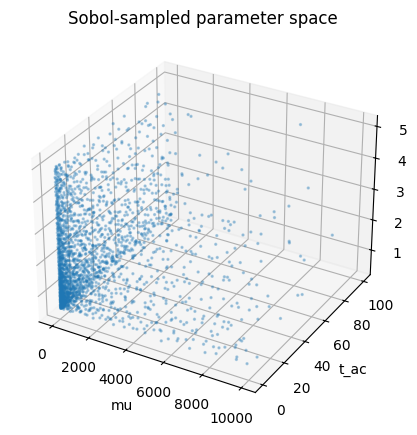

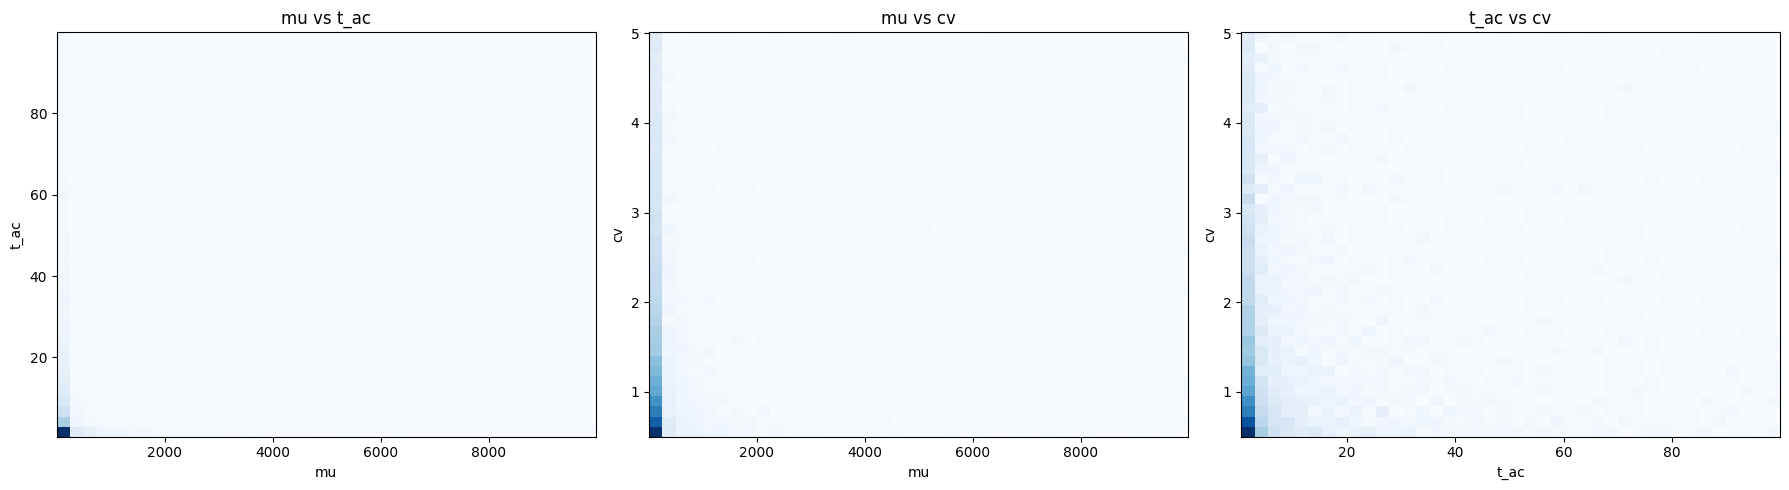

In [6]:
from scipy.stats import qmc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

MU_MIN, MU_MAX = 1, 1e4
TAC_MIN, TAC_MAX = 10 ** -0.3, 10 ** 2
CV_MIN, CV_MAX = 10 ** -0.3, 10 ** 0.7

sampler = qmc.Sobol(d=3, scramble=True, seed=42)
unit_samples = sampler.random(2048)
log_mu = np.log10(MU_MIN) + unit_samples[:,0]*(np.log10(MU_MAX)-np.log10(MU_MIN))
log_tac = np.log10(TAC_MIN) + unit_samples[:,1]*(np.log10(TAC_MAX)-np.log10(TAC_MIN))
log_cv = np.log10(CV_MIN) + unit_samples[:,2]*(np.log10(CV_MAX)-np.log10(CV_MIN))
mu_sobol = 10 ** log_mu
t_ac_sobol = 10 ** log_tac
cv_sobol = 10 ** log_cv

df_sobol = pd.DataFrame({'mu':mu_sobol,'t_ac':t_ac_sobol,'cv':cv_sobol})
print(f"mu range {df_sobol['mu'].min():.2f} to {df_sobol['mu'].max():.2f}")
print(f"t_ac range {df_sobol['t_ac'].min():.2f} to {df_sobol['t_ac'].max():.2f}")
print(f"cv range {df_sobol['cv'].min():.2f} to {df_sobol['cv'].max():.2f}")

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_sobol['mu'], df_sobol['t_ac'], df_sobol['cv'], s=2, alpha=0.3)
ax.set_xlabel('mu')
ax.set_ylabel('t_ac')
ax.set_zlabel('cv')
ax.set_title('Sobol-sampled parameter space')
plt.show()

fig, axes = plt.subplots(1,3, figsize=(18,5))
axes[0].hist2d(df_sobol['mu'], df_sobol['t_ac'], bins=40, cmap='Blues')
axes[0].set_xlabel('mu'); axes[0].set_ylabel('t_ac'); axes[0].set_title('mu vs t_ac')
axes[1].hist2d(df_sobol['mu'], df_sobol['cv'], bins=40, cmap='Blues')
axes[1].set_xlabel('mu'); axes[1].set_ylabel('cv'); axes[1].set_title('mu vs cv')
axes[2].hist2d(df_sobol['t_ac'], df_sobol['cv'], bins=40, cmap='Blues')
axes[2].set_xlabel('t_ac'); axes[2].set_ylabel('cv'); axes[2].set_title('t_ac vs cv')
plt.tight_layout()
plt.show()
